In [2]:
from qslamdesignparams import GLOBALDICT
from riskanalysis import CreateQslamExpt as riskqslam
from riskanalysis import NaiveEstimator

import numpy as np
import matplotlib.pyplot as plt
import copy
import sys
import traceback

#### New Default Parameter Regime

In this calibration script, we first change the defaults for the qslam_r parameter regimes using the output of previous calibration results. 

These calibration results suggest that 
 - The number of iterations and the number of measurements per qubit have the maximla effect on reducing RMS error
 - For a fixed measurement budget, the number of iterations (containing different qubit locations) tends to reduce RMS error compared to increasing the quality of information at each node (msmts per qubit)

In [3]:
change_MAX_NUM_ITERATIONS = 100
change_MSMTS_PER_NODE = 5
total_msmt_budget = change_MSMTS_PER_NODE * change_MAX_NUM_ITERATIONS 
print "Total Msmt Budget", total_msmt_budget

Total Msmt Budget 500


Next, one fixes the measurement budget and the number of iterations and performs scans of sigmoid and quantisation uncertainity. As these are quite low in simulations (no noise has been applied, fields are deterministic), low values tend to perform better than high values but no clear trend is seen. In lieu of a brute force approach, we take the minimal RMS values from the scan to estimate noise variance strengths. 

In [4]:
change_SIGMOID_APPROX_ERROR = 10.0**(-6)
change_QUANTISATION_UNCERTY = 10.0**(-4)

When setting particle tree configuration, calibrations suggest that 
 - keeping the total measurement budget should be on order of (or <= to) the number of alpha * beta particles
 - that the number of alpha particles > number of beta particles

In [5]:
change_P_ALPHA = 5 #25
change_P_BETA = 3 #10

total_particle_budget = change_P_ALPHA * change_P_BETA 
print "Total Particle Budget", total_particle_budget
print "Total particle Budget is ", float(total_particle_budget) / float(total_msmt_budget), " of Msmt Budget"

Total Particle Budget 15
Total particle Budget is  0.03  of Msmt Budget


For the forgetting factor ratios, a Uniform field yielded choices of moderate forgetting factors (physical: quasi ratios of 30/70, 40/60, 50/50, 60/40) whereas a Gaussian field resulted in rapid forgetting factors (80/20, 90/10, 100/0). This is good as the algorithm structure responds to spatial resolution implications, and hence means that the values of the forgetting factors can be optimised somewhat meaningfully. 

To cope for a variety of learning scenarios, we choose the forgetting factor of approx < 50/50 (arbitrarily) as a default value:

In [6]:
change_LAMBDA_1 = 0.9999
change_LAMBDA_2 = 0.9864

In [7]:
MAPTYPE = 'Uniform'

#### Update Default Settings

In [8]:
GLOBALDICT["MODELDESIGN"]["MAX_NUM_ITERATIONS"] = change_MAX_NUM_ITERATIONS
GLOBALDICT["MODELDESIGN"]["MSMTS_PER_NODE"] = change_MSMTS_PER_NODE
GLOBALDICT["NOISEPARAMS"]["SIGMOID_APPROX_ERROR"]["SIGMA"] = change_SIGMOID_APPROX_ERROR
GLOBALDICT["NOISEPARAMS"]["QUANTISATION_UNCERTY"]["SIGMA"] = change_QUANTISATION_UNCERTY
GLOBALDICT["MODELDESIGN"]["P_ALPHA"] = change_P_ALPHA
GLOBALDICT["MODELDESIGN"]["P_BETA"] = change_P_BETA
GLOBALDICT["MODELDESIGN"]["LAMBDA_1"] = change_LAMBDA_1
GLOBALDICT["MODELDESIGN"]["LAMBDA_2"] = change_LAMBDA_2

#### Test Run X7

Measurement Iterations:  5


/home/riddhisw/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


Variation  1 successful.
Variation  2 successful.
Variation  3 successful.
Variation  4 successful.
Variation  5 successful.


particlesets.py:162: RuntimeWarning: overflow encountered in double_scalars
  normalisation = 1.0/unnormalised_total
particlesets.py:163: RuntimeWarning: invalid value encountered in multiply
  return normalisation*raw_weights


Variation  6 successful.


qslamr.py:463: RuntimeWarning: invalid value encountered in multiply
  posterior_weights.append(alpha_particle.weight*beta_alpha_j_weights)


Variation  7 successful.
Variation  8 successful.
Variation  9 successful.
Variation  10 successful.


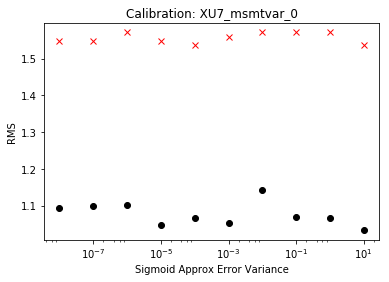

------ completed a measurement iteration -----



Measurement Iterations:  25
Variation  1 successful.
Variation  2 successful.
Variation  3 successful.
Variation  4 successful.
Variation  5 successful.
Variation  6 successful.
Variation  7 successful.
Variation  8 successful.
Variation  9 successful.
Variation  10 successful.


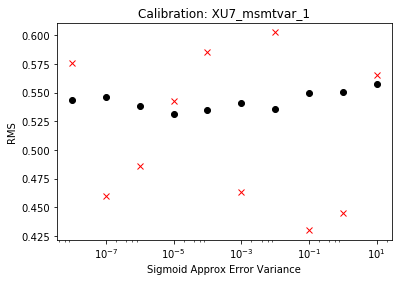

------ completed a measurement iteration -----



Measurement Iterations:  50
Variation  1 successful.
Variation  2 successful.
Variation  3 successful.
Variation  4 successful.
Variation  5 successful.
Variation  6 successful.
Variation  7 successful.
Variation  8 successful.
Variation  9 successful.
Variation  10 successful.


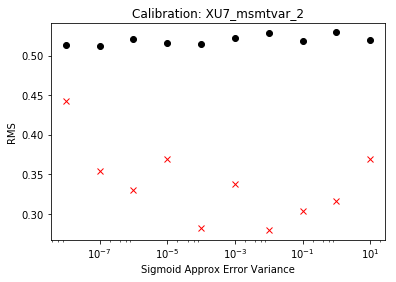

------ completed a measurement iteration -----



Measurement Iterations:  75
Variation  1 successful.
Variation  2 successful.
Variation  3 successful.
Variation  4 successful.
Variation  5 successful.
Variation  6 successful.
Variation  7 successful.
Variation  8 successful.
Variation  9 successful.
Variation  10 successful.


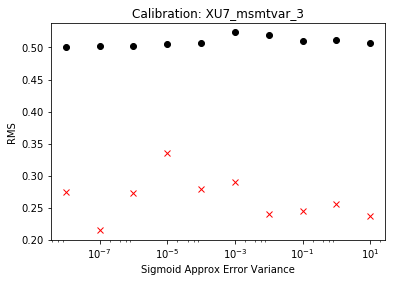

------ completed a measurement iteration -----



Measurement Iterations:  100
Variation  1 successful.
Variation  2 successful.
Variation  3 successful.
Variation  4 successful.
Variation  5 successful.
Variation  6 successful.
Variation  7 successful.
Variation  8 successful.
Variation  9 successful.
Variation  10 successful.


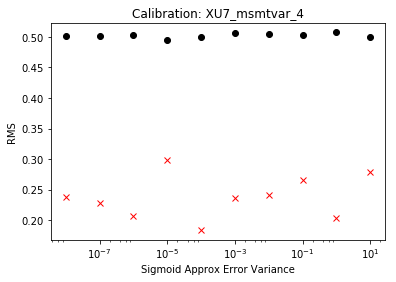

------ completed a measurement iteration -----



Measurement Iterations:  125
Variation  1 successful.
Variation  2 successful.
Variation  3 successful.
Variation  4 successful.
Variation  5 successful.
Variation  6 successful.
Variation  7 successful.
Variation  8 successful.
Variation  9 successful.
Variation  10 successful.


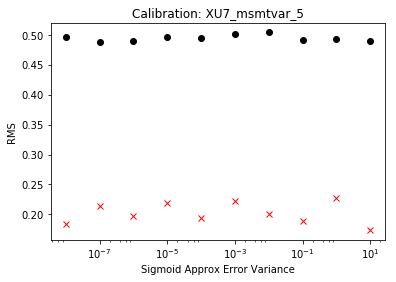

------ completed a measurement iteration -----





In [8]:
msmt_param_scan = [5, 25, 50, 75, 100, 125]
var_param_x7 = [0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]


savetopath = './calibrations_data/'

for idx_msmtvar in range(len(msmt_param_scan)):
    
    testcase_ID = 'XU7' + '_msmtvar_' + str(idx_msmtvar)
    print "Measurement Iterations: ", msmt_param_scan[idx_msmtvar]
    

    var_err_x7 = np.zeros(len(var_param_x7))
    emp_err_x7 = np.zeros(len(var_param_x7))

    plt.figure()

    for idx_var in range(len(var_param_x7)):

        risk_map = 0.
        empirical_state = 0.
        vardict = copy.deepcopy(GLOBALDICT)
        
        vardict["MODELDESIGN"]["MAX_NUM_ITERATIONS"] = msmt_param_scan[idx_msmtvar]
        vardict["NOISEPARAMS"]["SIGMOID_APPROX_ERROR"]["SIGMA"] = var_param_x7[idx_var]
        vardict["MODELDESIGN"]["ID"] = savetopath + testcase_ID + '_v_' + str(idx_var + 1)
        
        risk_map = riskqslam(truthtype='Gaussian', **vardict)

        try:
            risk_map.naive_implementation(randomise='OFF')
            print "Variation ", idx_var + 1, "successful." 
            qslam_errs = np.asarray(risk_map.macro_residuals)
            var_err_x7[idx_var] = (1.0/ np.sqrt(qslam_errs.shape[2]))*np.mean(np.linalg.norm(qslam_errs[0,:,:], axis=1), axis=0)
            plt.plot(var_param_x7[idx_var], var_err_x7[idx_var], 'ko')

        except :
            print "Variation ", idx_var + 1, "was not completed"
            print "Error information:"
            print "Type", sys.exc_info()[0]
            print "Value", sys.exc_info()[1]
            print "Traceback", traceback.format_exc()

        empirical_state = NaiveEstimator(typeofmap=MAPTYPE)
        total_msmt_budget_var =  msmt_param_scan[idx_msmtvar]*vardict["MODELDESIGN"]["MSMTS_PER_NODE"]
        empirical_state.msmt_per_node = total_msmt_budget_var / len(GLOBALDICT["GRIDDICT"])
        maperrors = empirical_state.get_empirical_est()
        emp_err_x7[idx_var] = (1.0/ np.sqrt(maperrors.shape[0]))*np.linalg.norm(maperrors)
        plt.plot(var_param_x7[idx_var], emp_err_x7[idx_var], 'rx')

    plt.title('Calibration: ' + testcase_ID)
    plt.ylabel('RMS')
    plt.xlabel('Sigmoid Approx Error Variance')
    plt.xscale('log')
    # plt.ylim([0, 1])
    plt.show()  
     
    print "------ completed a measurement iteration -----"
    print 
    print 
    print

#### X8: QUANTISATION_UNCERTY

Measurement Iterations:  5
Variation  1 successful.
Variation  2 successful.
Variation  3 successful.
Variation  4 successful.
Variation  5 successful.
Variation  6 successful.
Variation  7 successful.
Variation  8 successful.
Variation  9 successful.
Variation  10 successful.
Variation  11 successful.


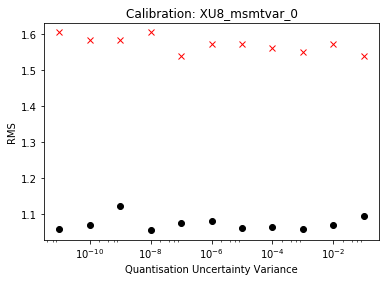

------ completed a measurement iteration -----



Measurement Iterations:  25
Variation  1 successful.
Variation  2 successful.
Variation  3 successful.
Variation  4 successful.
Variation  5 successful.
Variation  6 successful.
Variation  7 successful.
Variation  8 successful.
Variation  9 successful.
Variation  10 successful.
Variation  11 successful.


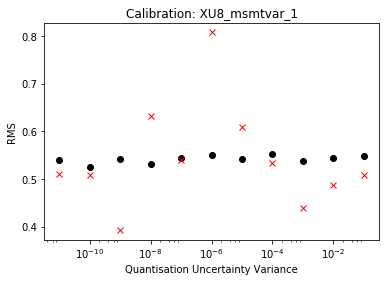

------ completed a measurement iteration -----



Measurement Iterations:  50
Variation  1 successful.
Variation  2 successful.
Variation  3 successful.
Variation  4 successful.
Variation  5 successful.
Variation  6 successful.
Variation  7 successful.
Variation  8 successful.
Variation  9 successful.
Variation  10 successful.
Variation  11 successful.


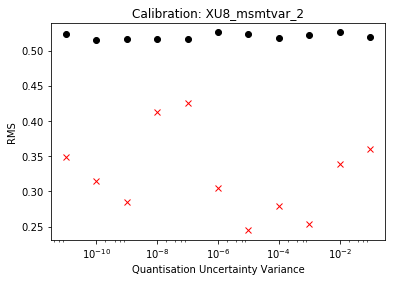

------ completed a measurement iteration -----



Measurement Iterations:  75
Variation  1 successful.
Variation  2 successful.
Variation  3 successful.
Variation  4 successful.
Variation  5 successful.
Variation  6 successful.
Variation  7 successful.
Variation  8 successful.
Variation  9 successful.
Variation  10 successful.
Variation  11 successful.


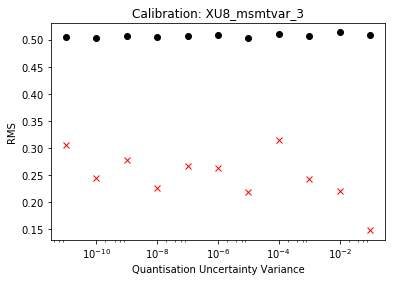

------ completed a measurement iteration -----



Measurement Iterations:  100
Variation  1 successful.
Variation  2 successful.
Variation  3 successful.
Variation  4 successful.
Variation  5 successful.
Variation  6 successful.
Variation  7 successful.
Variation  8 successful.
Variation  9 successful.
Variation  10 successful.
Variation  11 successful.


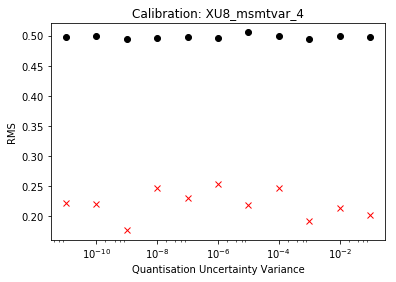

------ completed a measurement iteration -----



Measurement Iterations:  125
Variation  1 successful.
Variation  2 successful.
Variation  3 successful.
Variation  4 successful.
Variation  5 successful.
Variation  6 successful.
Variation  7 successful.
Variation  8 successful.
Variation  9 successful.
Variation  10 successful.
Variation  11 successful.


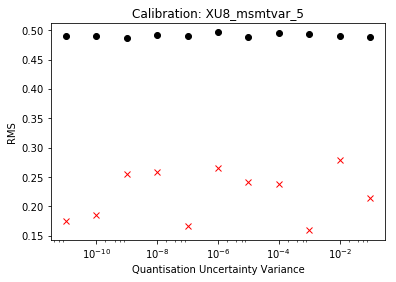

------ completed a measurement iteration -----





In [9]:
msmt_param_scan = [5, 25, 50, 75, 100, 125]
var_param_x8 = [10.0**(-11), 10.0**(-10), 0.000000001, 0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]


savetopath = './calibrations_data/'

for idx_msmtvar in range(len(msmt_param_scan)):
    
    testcase_ID = 'XU8' + '_msmtvar_' + str(idx_msmtvar)
    print "Measurement Iterations: ", msmt_param_scan[idx_msmtvar]
    

    var_err_x8 = np.zeros(len(var_param_x8))
    emp_err_x8 = np.zeros(len(var_param_x8))

    plt.figure()

    for idx_var in range(len(var_param_x8)):

        risk_map = 0.
        empirical_state = 0.
        vardict = copy.deepcopy(GLOBALDICT)
        
        vardict["MODELDESIGN"]["MAX_NUM_ITERATIONS"] = msmt_param_scan[idx_msmtvar]
        vardict["NOISEPARAMS"]["QUANTISATION_UNCERTY"]["SIGMA"] = var_param_x8[idx_var]
        vardict["MODELDESIGN"]["ID"] = savetopath + testcase_ID + '_v_' + str(idx_var + 1)
        
        risk_map = riskqslam(truthtype='Gaussian', **vardict)

        try:
            risk_map.naive_implementation(randomise='OFF')
            print "Variation ", idx_var + 1, "successful." 
            qslam_errs = np.asarray(risk_map.macro_residuals)
            var_err_x8[idx_var] = (1.0/ np.sqrt(qslam_errs.shape[2]))*np.mean(np.linalg.norm(qslam_errs[0,:,:], axis=1), axis=0)
            plt.plot(var_param_x8[idx_var], var_err_x8[idx_var], 'ko')

        except :
            print "Variation ", idx_var + 1, "was not completed"
            print "Error information:"
            print "Type", sys.exc_info()[0]
            print "Value", sys.exc_info()[1]
            print "Traceback", traceback.format_exc()

        empirical_state = NaiveEstimator(typeofmap=MAPTYPE)
        total_msmt_budget_var =  msmt_param_scan[idx_msmtvar]*vardict["MODELDESIGN"]["MSMTS_PER_NODE"]
        empirical_state.msmt_per_node = total_msmt_budget_var / len(GLOBALDICT["GRIDDICT"])
        maperrors = empirical_state.get_empirical_est()
        emp_err_x8[idx_var] = (1.0/ np.sqrt(maperrors.shape[0]))*np.linalg.norm(maperrors)
        plt.plot(var_param_x8[idx_var], emp_err_x8[idx_var], 'rx')

    plt.title('Calibration: ' + testcase_ID)
    plt.ylabel('RMS')
    plt.xlabel('Quantisation Uncertainty Variance')
    plt.xscale('log')
    # plt.ylim([0, 1])
    plt.show()  
     
    print "------ completed a measurement iteration -----"
    print 
    print 
    print

#### X9: MSMTS PER NODE

Measurement Iterations:  5
Variation  1 successful.
Variation  2 successful.
Variation  3 successful.
Variation  4 successful.
Variation  5 successful.
Variation  6 successful.
Variation  7 successful.


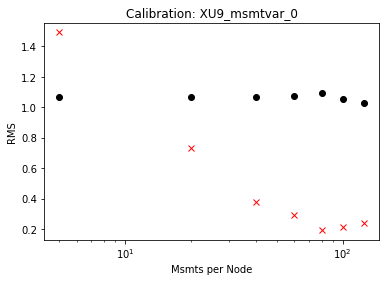

------ completed a measurement iteration -----



Measurement Iterations:  25
Variation  1 successful.
Variation  2 successful.
Variation  3 successful.
Variation  4 successful.
Variation  5 successful.
Variation  6 successful.
Variation  7 successful.


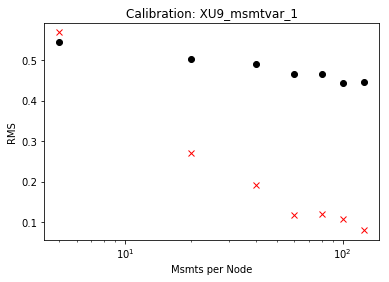

------ completed a measurement iteration -----



Measurement Iterations:  50
Variation  1 successful.
Variation  2 successful.
Variation  3 successful.
Variation  4 successful.
Variation  5 successful.
Variation  6 successful.
Variation  7 successful.


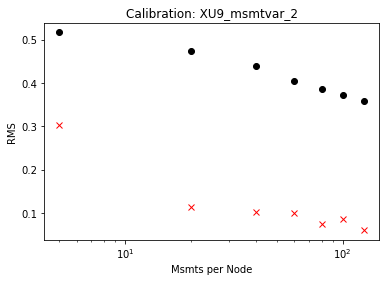

------ completed a measurement iteration -----



Measurement Iterations:  75
Variation  1 successful.
Variation  2 successful.
Variation  3 successful.
Variation  4 successful.
Variation  5 successful.
Variation  6 successful.
Variation  7 successful.


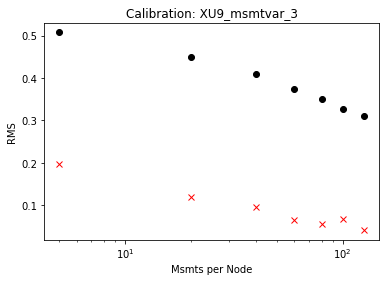

------ completed a measurement iteration -----



Measurement Iterations:  100
Variation  1 successful.
Variation  2 successful.
Variation  3 successful.
Variation  4 successful.
Variation  5 successful.
Variation  6 successful.
Variation  7 successful.


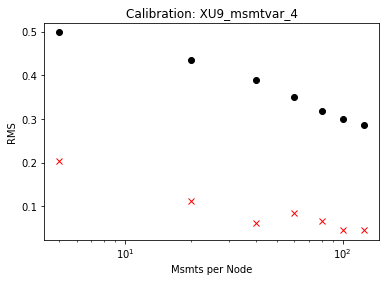

------ completed a measurement iteration -----



Measurement Iterations:  125
Variation  1 successful.
Variation  2 successful.
Variation  3 successful.
Variation  4 successful.
Variation  5 successful.
Variation  6 successful.
Variation  7 successful.


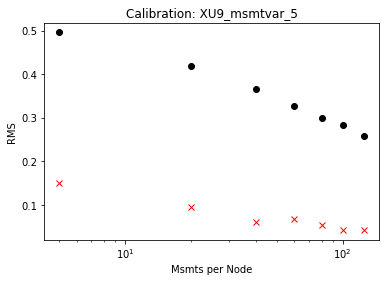

------ completed a measurement iteration -----





In [10]:
msmt_param_scan = [5, 25, 50, 75, 100, 125]
var_param_x9 = [5, 20, 40, 60, 80, 100, 125]


savetopath = './calibrations_data/'

for idx_msmtvar in range(len(msmt_param_scan)):
    
    testcase_ID = 'XU9' + '_msmtvar_' + str(idx_msmtvar)
    print "Measurement Iterations: ", msmt_param_scan[idx_msmtvar]
    

    var_err_x9 = np.zeros(len(var_param_x9))
    emp_err_x9 = np.zeros(len(var_param_x9))

    plt.figure()

    for idx_var in range(len(var_param_x9)):

        risk_map = 0.
        empirical_state = 0.
        vardict = copy.deepcopy(GLOBALDICT)
        
        vardict["MODELDESIGN"]["MAX_NUM_ITERATIONS"] = msmt_param_scan[idx_msmtvar]
        vardict["MODELDESIGN"]["MSMTS_PER_NODE"] = var_param_x9[idx_var]
        vardict["MODELDESIGN"]["ID"] = savetopath + testcase_ID + '_v_' + str(idx_var + 1)
        
        risk_map = riskqslam(truthtype='Gaussian', **vardict)

        try:
            risk_map.naive_implementation(randomise='OFF')
            print "Variation ", idx_var + 1, "successful." 
            qslam_errs = np.asarray(risk_map.macro_residuals)
            var_err_x9[idx_var] = (1.0/ np.sqrt(qslam_errs.shape[2]))*np.mean(np.linalg.norm(qslam_errs[0,:,:], axis=1), axis=0)
            plt.plot(var_param_x9[idx_var], var_err_x9[idx_var], 'ko')

        except :
            print "Variation ", idx_var + 1, "was not completed"
            print "Error information:"
            print "Type", sys.exc_info()[0]
            print "Value", sys.exc_info()[1]
            print "Traceback", traceback.format_exc()

        empirical_state = NaiveEstimator(typeofmap=MAPTYPE)
        total_msmt_budget_var =  msmt_param_scan[idx_msmtvar]*vardict["MODELDESIGN"]["MSMTS_PER_NODE"]
        empirical_state.msmt_per_node = total_msmt_budget_var / len(GLOBALDICT["GRIDDICT"])
        maperrors = empirical_state.get_empirical_est()
        emp_err_x9[idx_var] = (1.0/ np.sqrt(maperrors.shape[0]))*np.linalg.norm(maperrors)
        plt.plot(var_param_x9[idx_var], emp_err_x9[idx_var], 'rx')

    plt.title('Calibration: ' + testcase_ID)
    plt.ylabel('RMS')
    plt.xlabel('Msmts per Node')
    plt.xscale('log')
    # plt.ylim([0, 1])
    plt.show()  
     
    print "------ completed a measurement iteration -----"
    print 
    print 
    print

#### X10 : R_MIN Prior

Measurement Iterations:  5
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Cont

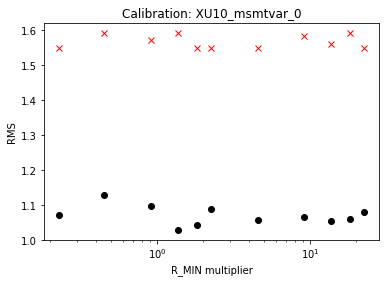

------ completed a measurement iteration -----



Measurement Iterations:  25
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Cont

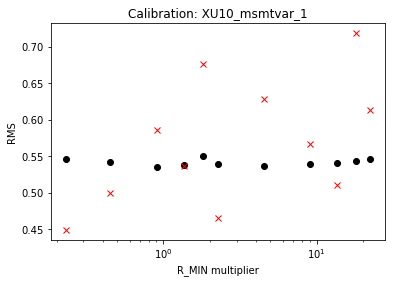

------ completed a measurement iteration -----



Measurement Iterations:  50
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Cont

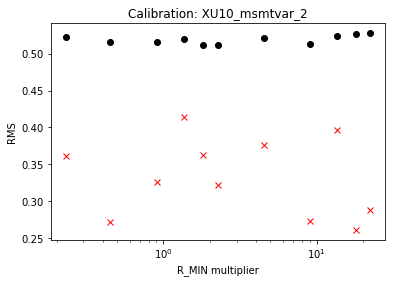

------ completed a measurement iteration -----



Measurement Iterations:  75
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Cont

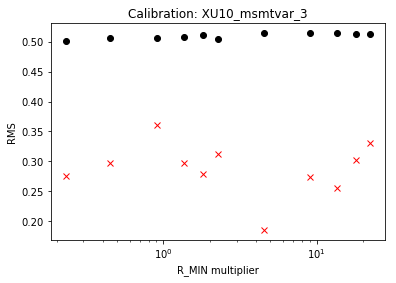

------ completed a measurement iteration -----



Measurement Iterations:  100
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Con

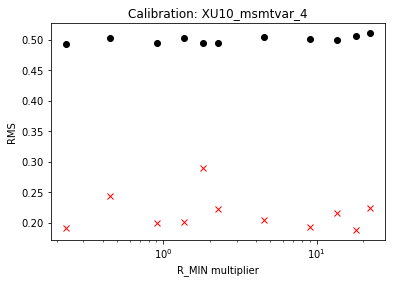

------ completed a measurement iteration -----



Measurement Iterations:  125
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Control List empty; randomly chosen qubit on grid.
Con

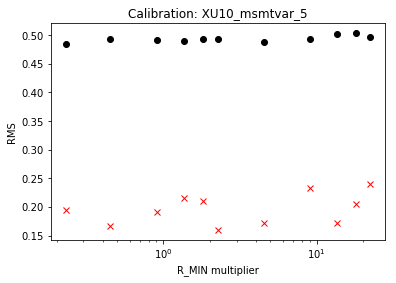

------ completed a measurement iteration -----





In [11]:
msmt_param_scan = [5, 25, 50, 75, 100, 125]
var_param_x10 = [0.23, 0.45, 0.91, 1.36, 1.81, 2.26, 4.53, 9.05, 13.58, 18.10, 22.40]


savetopath = './calibrations_data/'

for idx_msmtvar in range(len(msmt_param_scan)):
    
    testcase_ID = 'XU10' + '_msmtvar_' + str(idx_msmtvar)
    print "Measurement Iterations: ", msmt_param_scan[idx_msmtvar]
    

    var_err_x10 = np.zeros(len(var_param_x10))
    emp_err_x10 = np.zeros(len(var_param_x10))

    plt.figure()

    for idx_var in range(len(var_param_x10)):

        risk_map = 0.
        empirical_state = 0.
        vardict = copy.deepcopy(GLOBALDICT)
        
        vardict["MODELDESIGN"]["MAX_NUM_ITERATIONS"] = msmt_param_scan[idx_msmtvar]
        vardict["MODELDESIGN"]["MULTIPLER_R_MIN"] = var_param_x10[idx_var]
        vardict["MODELDESIGN"]["ID"] = savetopath + testcase_ID + '_v_' + str(idx_var + 1)
        
        risk_map = riskqslam(truthtype='Gaussian', **vardict)

        try:
            risk_map.naive_implementation(randomise='OFF')
            print "Variation ", idx_var + 1, "successful." 
            qslam_errs = np.asarray(risk_map.macro_residuals)
            var_err_x10[idx_var] = (1.0/ np.sqrt(qslam_errs.shape[2]))*np.mean(np.linalg.norm(qslam_errs[0,:,:], axis=1), axis=0)
            plt.plot(var_param_x10[idx_var], var_err_x10[idx_var], 'ko')

        except :
            print "Variation ", idx_var + 1, "was not completed"
            print "Error information:"
            print "Type", sys.exc_info()[0]
            print "Value", sys.exc_info()[1]
            print "Traceback", traceback.format_exc()

        empirical_state = NaiveEstimator(typeofmap=MAPTYPE)
        total_msmt_budget_var =  msmt_param_scan[idx_msmtvar]*vardict["MODELDESIGN"]["MSMTS_PER_NODE"]
        empirical_state.msmt_per_node = total_msmt_budget_var / len(GLOBALDICT["GRIDDICT"])
        maperrors = empirical_state.get_empirical_est()
        emp_err_x10[idx_var] = (1.0/ np.sqrt(maperrors.shape[0]))*np.linalg.norm(maperrors)
        plt.plot(var_param_x10[idx_var], emp_err_x10[idx_var], 'rx')

    plt.title('Calibration: ' + testcase_ID)
    plt.ylabel('RMS')
    plt.xlabel('R_MIN multiplier')
    plt.xscale('log')
    # plt.ylim([0, 1])
    plt.show()  
     
    print "------ completed a measurement iteration -----"
    print 
    print 
    print

#### X11: Particle Tree Configurations

Measurement Iterations:  5
Variation  1 successful.
Variation  2 successful.
Variation  3 successful.
Variation  4 successful.
Variation  5 successful.
Variation  6 successful.
Variation  7 successful.
Variation  8 successful.
Variation  9 successful.
Variation  10 successful.
Variation  11 successful.
Variation  12 successful.
Variation  13 successful.
Variation  14 successful.


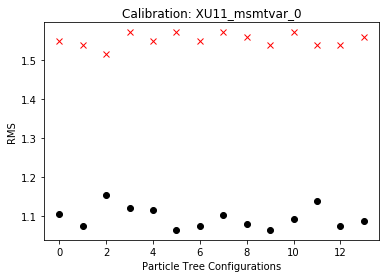

------ completed a measurement iteration -----



Measurement Iterations:  25
Variation  1 successful.
Variation  2 successful.
Variation  3 successful.
Variation  4 successful.
Variation  5 successful.
Variation  6 successful.
Variation  7 successful.
Variation  8 successful.
Variation  9 successful.
Variation  10 successful.
Variation  11 successful.
Variation  12 successful.
Variation  13 successful.
Variation  14 successful.


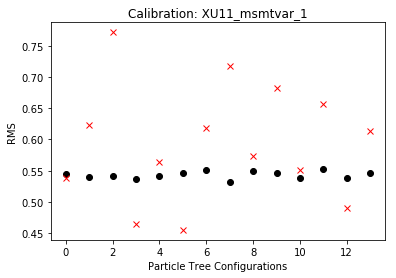

------ completed a measurement iteration -----



Measurement Iterations:  50
Variation  1 successful.
Variation  2 successful.
Variation  3 successful.
Variation  4 successful.
Variation  5 successful.
Variation  6 successful.
Variation  7 successful.
Variation  8 successful.
Variation  9 successful.
Variation  10 successful.
Variation  11 successful.
Variation  12 successful.
Variation  13 successful.
Variation  14 successful.


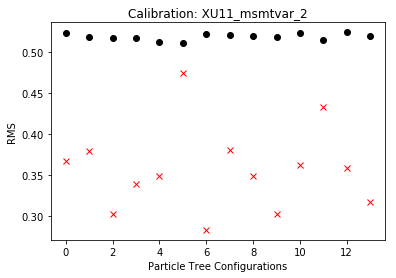

------ completed a measurement iteration -----



Measurement Iterations:  75
Variation  1 successful.
Variation  2 successful.
Variation  3 was not completed
Error information:
Type <type 'exceptions.KeyboardInterrupt'>
Value 
Traceback Traceback (most recent call last):
  File "<ipython-input-13-4fe120a3a841>", line 33, in <module>
    risk_map.naive_implementation(randomise='OFF')
  File "riskanalysis.py", line 279, in naive_implementation
    full_bayes_map = self.one_bayes_trial(samples=fix_hyperparams)
  File "riskanalysis.py", line 245, in one_bayes_trial
    posterior, errors = self.map_loss_trial(true_map_, **SAMPLE_GLOBAL_MODEL)
  File "riskanalysis.py", line 202, in map_loss_trial
    var_thres=var_thres_)
  File "qslamr.py", line 241, in qslamr
    next_control_neighbourhood = self.particlefilter(msmt_control_pair)
  File "qslamr.py", line 310, in particlefilter
    **self.LikelihoodObj.WEIGHTFUNCDICT_BETA)
  File "qslamr.py", line 462, in ComputePosteriorWeights
    beta_a

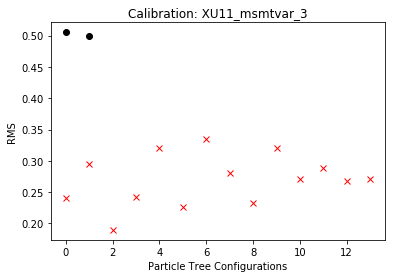

------ completed a measurement iteration -----



Measurement Iterations:  100
Variation  1 was not completed
Error information:
Type <type 'exceptions.KeyboardInterrupt'>
Value 
Traceback Traceback (most recent call last):
  File "<ipython-input-13-4fe120a3a841>", line 33, in <module>
    risk_map.naive_implementation(randomise='OFF')
  File "riskanalysis.py", line 279, in naive_implementation
    full_bayes_map = self.one_bayes_trial(samples=fix_hyperparams)
  File "riskanalysis.py", line 245, in one_bayes_trial
    posterior, errors = self.map_loss_trial(true_map_, **SAMPLE_GLOBAL_MODEL)
  File "riskanalysis.py", line 202, in map_loss_trial
    var_thres=var_thres_)
  File "qslamr.py", line 241, in qslamr
    next_control_neighbourhood = self.particlefilter(msmt_control_pair)
  File "qslamr.py", line 310, in particlefilter
    **self.LikelihoodObj.WEIGHTFUNCDICT_BETA)
  File "qslamr.py", line 462, in ComputePosteriorWeights
    beta_alpha_j_weights = self.generate_beta_layer(alpha_p

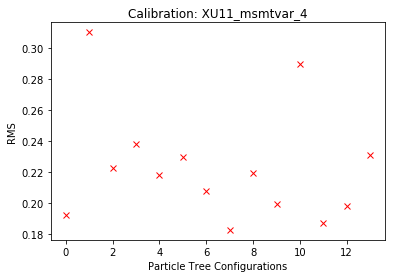

------ completed a measurement iteration -----



Measurement Iterations:  125
Variation  1 was not completed
Error information:
Type <type 'exceptions.KeyboardInterrupt'>
Value 
Traceback Traceback (most recent call last):
  File "<ipython-input-13-4fe120a3a841>", line 33, in <module>
    risk_map.naive_implementation(randomise='OFF')
  File "riskanalysis.py", line 279, in naive_implementation
    full_bayes_map = self.one_bayes_trial(samples=fix_hyperparams)
  File "riskanalysis.py", line 245, in one_bayes_trial
    posterior, errors = self.map_loss_trial(true_map_, **SAMPLE_GLOBAL_MODEL)
  File "riskanalysis.py", line 202, in map_loss_trial
    var_thres=var_thres_)
  File "qslamr.py", line 241, in qslamr
    next_control_neighbourhood = self.particlefilter(msmt_control_pair)
  File "qslamr.py", line 311, in particlefilter
    self.ResampleParticles(posterior_weights) # no QubitGrid update
  File "qslamr.py", line 583, in ResampleParticles
    new_alpha_list = self.collapse_beta(new

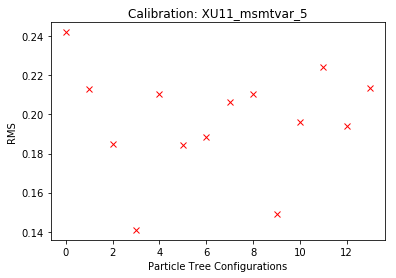

------ completed a measurement iteration -----





In [13]:
msmt_param_scan = [5, 25, 50, 75, 100, 125]

var_param_x11_a = [25, 25, 25, 25, 25, 25, 25, 25, 10, 20, 40, 60, 80, 100]
var_param_x11_b = [2, 4, 6, 8, 10, 20, 40, 10, 10, 10, 10, 10, 10, 10]

savetopath = './calibrations_data/'

for idx_msmtvar in range(len(msmt_param_scan)):
    
    testcase_ID = 'XU11' + '_msmtvar_' + str(idx_msmtvar)
    print "Measurement Iterations: ", msmt_param_scan[idx_msmtvar]
    

    var_err_x11 = np.zeros(len(var_param_x11_a))
    emp_err_x11 = np.zeros(len(var_param_x11_a))

    plt.figure()

    for idx_var in range(len(var_param_x11_a)):

        risk_map = 0.
        empirical_state = 0.
        vardict = copy.deepcopy(GLOBALDICT)
        
        vardict["MODELDESIGN"]["MAX_NUM_ITERATIONS"] = msmt_param_scan[idx_msmtvar]
        vardict["MODELDESIGN"]["P_ALPHA"] = var_param_x11_a[idx_var]
        vardict["MODELDESIGN"]["P_BETA"] = var_param_x11_b[idx_var]
        vardict["MODELDESIGN"]["ID"] = savetopath + testcase_ID + '_v_' + str(idx_var + 1)
        
        risk_map = riskqslam(truthtype='Gaussian', **vardict)

        try:
            risk_map.naive_implementation(randomise='OFF')
            print "Variation ", idx_var + 1, "successful." 
            qslam_errs = np.asarray(risk_map.macro_residuals)
            var_err_x11[idx_var] = (1.0/ np.sqrt(qslam_errs.shape[2]))*np.mean(np.linalg.norm(qslam_errs[0,:,:], axis=1), axis=0)
            plt.plot(idx_var, var_err_x11[idx_var], 'ko')

        except :
            print "Variation ", idx_var + 1, "was not completed"
            print "Error information:"
            print "Type", sys.exc_info()[0]
            print "Value", sys.exc_info()[1]
            print "Traceback", traceback.format_exc()

        empirical_state = NaiveEstimator(typeofmap=MAPTYPE)
        total_msmt_budget_var =  msmt_param_scan[idx_msmtvar]*vardict["MODELDESIGN"]["MSMTS_PER_NODE"]
        empirical_state.msmt_per_node = total_msmt_budget_var / len(GLOBALDICT["GRIDDICT"])
        maperrors = empirical_state.get_empirical_est()
        emp_err_x11[idx_var] = (1.0/ np.sqrt(maperrors.shape[0]))*np.linalg.norm(maperrors)
        plt.plot(idx_var, emp_err_x11[idx_var], 'rx')

    plt.title('Calibration: ' + testcase_ID)
    plt.ylabel('RMS')
    plt.xlabel('Particle Tree Configurations')
    # plt.xscale('log')
    # plt.ylim([0, 1])
    plt.show()  
     
    print "------ completed a measurement iteration -----"
    print 
    print 
    print

#### X12: Forgetting Factors

Measurement Iterations:  5


/home/riddhisw/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


Variation  1 successful.
Variation  2 successful.
Variation  3 successful.
Variation  4 successful.
Variation  5 successful.
Variation  6 successful.
Variation  7 successful.
Variation  8 successful.
Variation  9 successful.
Variation  10 successful.
Variation  11 successful.


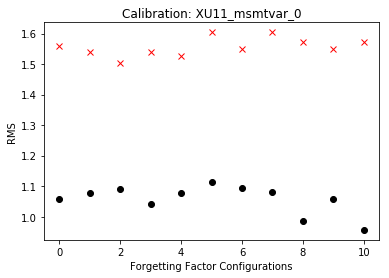

------ completed a measurement iteration -----



Measurement Iterations:  25
Variation  1 successful.
Variation  2 successful.


particlesets.py:162: RuntimeWarning: overflow encountered in double_scalars
  normalisation = 1.0/unnormalised_total
particlesets.py:163: RuntimeWarning: invalid value encountered in multiply
  return normalisation*raw_weights


Variation  3 successful.
Variation  4 successful.
Variation  5 successful.
Variation  6 successful.
Variation  7 successful.
Variation  8 successful.
Variation  9 successful.
Variation  10 successful.
Variation  11 successful.


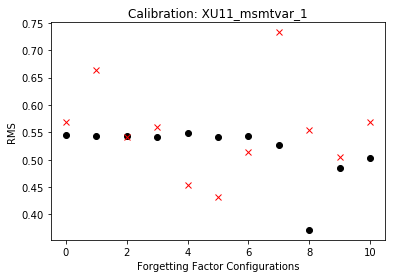

------ completed a measurement iteration -----



Measurement Iterations:  50
Variation  1 successful.
Variation  2 successful.
Variation  3 successful.
Variation  4 successful.
Variation  5 successful.
Variation  6 successful.
Variation  7 successful.
Variation  8 successful.
Variation  9 successful.
Variation  10 successful.
Variation  11 successful.


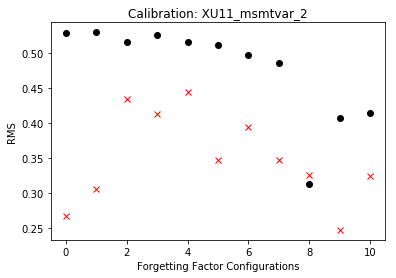

------ completed a measurement iteration -----



Measurement Iterations:  75
Variation  1 successful.
Variation  2 successful.
Variation  3 successful.
Variation  4 successful.
Variation  5 successful.
Variation  6 successful.
Variation  7 successful.
Variation  8 successful.
Variation  9 successful.
Variation  10 successful.
Variation  11 successful.


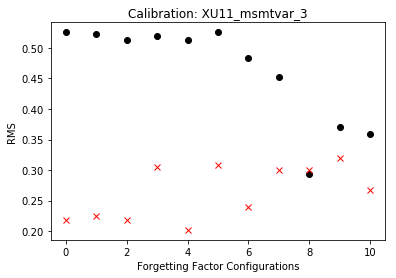

------ completed a measurement iteration -----



Measurement Iterations:  100
Variation  1 successful.
Variation  2 successful.
Variation  3 successful.
Variation  4 successful.
Variation  5 successful.
Variation  6 successful.
Variation  7 successful.
Variation  8 successful.
Variation  9 successful.
Variation  10 successful.
Variation  11 successful.


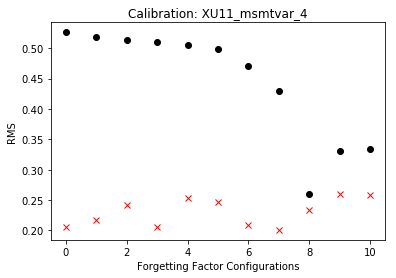

------ completed a measurement iteration -----



Measurement Iterations:  125
Variation  1 successful.
Variation  2 successful.
Variation  3 successful.
Variation  4 successful.
Variation  5 successful.
Variation  6 successful.
Variation  7 successful.
Variation  8 successful.
Variation  9 successful.
Variation  10 successful.
Variation  11 successful.


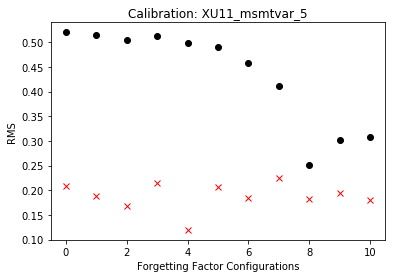

------ completed a measurement iteration -----





In [9]:
msmt_param_scan = [5, 25, 50, 75, 100, 125]

var_param_x12_a = [1, 1, 1, 1, 1, 1, 0.996, 0.99, 0.82, 0.965, 0]
var_param_x12_b = [1, 0.998, 0.9955, 0.993, 0.99, 0.9864, 0.982, 0.977, 0.968, 0.956, 0]

savetopath = './calibrations_data/'

for idx_msmtvar in range(len(msmt_param_scan)):
    
    testcase_ID = 'XU11' + '_msmtvar_' + str(idx_msmtvar)
    print "Measurement Iterations: ", msmt_param_scan[idx_msmtvar]
    

    var_err_x12 = np.zeros(len(var_param_x12_a))
    emp_err_x12 = np.zeros(len(var_param_x12_a))

    plt.figure()

    for idx_var in range(len(var_param_x12_a)):

        risk_map = 0.
        empirical_state = 0.
        vardict = copy.deepcopy(GLOBALDICT)
        
        vardict["MODELDESIGN"]["MAX_NUM_ITERATIONS"] = msmt_param_scan[idx_msmtvar]
        vardict["MODELDESIGN"]["LAMBDA_1"] = var_param_x12_a[idx_var]
        vardict["MODELDESIGN"]["LAMBDA_2"] = var_param_x12_b[idx_var]
        vardict["MODELDESIGN"]["ID"] = savetopath + testcase_ID + '_v_' + str(idx_var + 1)
        
        risk_map = riskqslam(truthtype='Gaussian', **vardict)

        try:
            risk_map.naive_implementation(randomise='OFF')
            print "Variation ", idx_var + 1, "successful." 
            qslam_errs = np.asarray(risk_map.macro_residuals)
            var_err_x12[idx_var] = (1.0/ np.sqrt(qslam_errs.shape[2]))*np.mean(np.linalg.norm(qslam_errs[0,:,:], axis=1), axis=0)
            plt.plot(idx_var, var_err_x12[idx_var], 'ko')

        except :
            print "Variation ", idx_var + 1, "was not completed"
            print "Error information:"
            print "Type", sys.exc_info()[0]
            print "Value", sys.exc_info()[1]
            print "Traceback", traceback.format_exc()

        empirical_state = NaiveEstimator(typeofmap=MAPTYPE)
        total_msmt_budget_var =  msmt_param_scan[idx_msmtvar]*vardict["MODELDESIGN"]["MSMTS_PER_NODE"]
        empirical_state.msmt_per_node = total_msmt_budget_var / len(GLOBALDICT["GRIDDICT"])
        maperrors = empirical_state.get_empirical_est()
        emp_err_x12[idx_var] = (1.0/ np.sqrt(maperrors.shape[0]))*np.linalg.norm(maperrors)
        plt.plot(idx_var, emp_err_x12[idx_var], 'rx')

    plt.title('Calibration: ' + testcase_ID)
    plt.ylabel('RMS')
    plt.xlabel('Forgetting Factor Configurations')
    # plt.xscale('log')
    # plt.ylim([0, 1])
    plt.show()  
     
    print "------ completed a measurement iteration -----"
    print 
    print 
    print